# Baseline model for claim classification

In this notebook, we'll explore basic ML models to train and make inferences about the veracity of environment related claims. These models, such as _linear regression_ and _naive bayes_, are simplier, faster and more easily interpretable than more advanced deep learning approaches. 

The results from this exercise will be used as reference point for the claim classification project. 

In [1]:
# import required libraries
import numpy as np 
import pandas as pd
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

### Load data

Import data from previously produced csv files

In [3]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")
val_df = pd.read_csv("../data/val_data.csv")

# remove nans. they cant be vectorized
train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

In [4]:
val_df.head()

,text,label
0,“this is [...] a brush rake. It's used for cle...,LIKELY_FALSE
1,and some plants – like algae which use carbon ...,LIKELY_TRUE
2,the carbon footprint on wind energy is signifi...,LIKELY_FALSE
3,warming of the climate system is unequivocal a...,LIKELY_TRUE
4,that humans are causing global warming is the ...,LIKELY_TRUE


### Separate features and labels

We’ll train on _clean_text_ and predict _label_

In [5]:
x_list = ['text']
y_list = ['label']

x_train, y_train = train_df[x_list], train_df[y_list]
x_test, y_test   = test_df[x_list], test_df[y_list]
x_val, y_val     = val_df[x_list], val_df[y_list]

y_train = y_train.values.ravel() # flaten so it's labels are 1D
y_test  = y_test.values.ravel() # flaten so it's labels are 1D
y_val   = y_val.values.ravel() # flaten so it's labels are 1D

print(x_train.shape)
print(y_train.shape)

(1388, 1)
(1388,)


### Baseline pipeline

We'll use **TF-IDF** (Term Frequency - Inverse Document Frequency) with **Logistic Regression**

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#### Model parameter optimization
Through grid scan

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

param_grid = [
    {"ngram_range": (1,1), "max_features": 5000, "class_weight": None},
    {"ngram_range": (1,2), "max_features": 5000, "class_weight": None},
    {"ngram_range": (1,2), "max_features": 10000, "class_weight": None},
    {"ngram_range": (1,2), "max_features": 20000, "class_weight": None},
    {"ngram_range": (1,2), "max_features": 5000,  "class_weight": "balanced"},
    {"ngram_range": (1,2), "max_features": 10000, "class_weight": "balanced"},
    #{"ngram_range": (1,3), "max_features": 20000, "class_weight": "balanced"},
]

results = []

for params in param_grid:
    clf_temp = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=params["ngram_range"],
            max_features=params["max_features"],
            stop_words="english"
        )),
        ("svc", LinearSVC(
            max_iter=2000,
            class_weight=params["class_weight"]
        ))
    ])

    clf_temp.fit(x_train["text"], y_train)
    y_pred_temp = clf_temp.predict(x_test["text"])

    acc = accuracy_score(y_test, y_pred_temp)
    f1_macro = f1_score(y_test, y_pred_temp, average="macro")

    results.append({
        "ngram_range": params["ngram_range"],
        "max_features": params["max_features"],
        "class_weight": params["class_weight"],
        "accuracy": acc,
        "f1_macro": f1_macro
    })

# Put in table
results_df = pd.DataFrame(results)
print(results_df)

  ngram_range  max_features class_weight  accuracy  f1_macro
0      (1, 1)          5000         None  0.711409  0.556824
1      (1, 2)          5000         None  0.721477  0.584742
2      (1, 2)         10000         None  0.724832  0.572199
3      (1, 2)         20000         None  0.714765  0.548026
4      (1, 2)          5000     balanced  0.671141  0.590866
5      (1, 2)         10000     balanced  0.697987  0.605982
6      (1, 2)         20000     balanced  0.691275  0.597226


Chose parameters based on tradeoff between accuracy and f1

In [8]:
max_features = 20000
ngram_range=(1,3)
class_weight="balanced"

### Baseline performance

Chose a model between logistic regression, random forest, and xgboost based on overall performance.

In [9]:
from sklearn.metrics import classification_report

In [10]:
from src.models import *
from sklearn.preprocessing import LabelEncoder

# XGBooost needs encoded labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes mapping: {'LIKELY_FALSE': np.int64(0), 'LIKELY_TRUE': np.int64(1)}


In [11]:
log_model = train_classic_model(x_train, y_train_enc, "logreg", ngram_range=ngram_range, max_features=max_features, class_weight=class_weight)
rf_model  = train_classic_model(x_train, y_train_enc, "rf", ngram_range=ngram_range, max_features=max_features, class_weight=class_weight)
svc_model = train_classic_model(x_train, y_train_enc, "svc", ngram_range=ngram_range, max_features=max_features, class_weight=class_weight)

results = []

models = {
        "Logistic Regression": log_model,
        "Random Forest": rf_model,
        "Linear SVC": svc_model
}

for name, model in models.items():
    
    preds = model.predict(x_test)

    acc = accuracy_score(y_test_enc, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test_enc, preds, average="weighted", zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3)
    })

pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.688,0.700,0.688,0.693
1,Random Forest,0.718,0.677,0.718,0.686
2,Linear SVC,0.695,0.688,0.695,0.691


Picking model to set baseline. Might re-optimize parameters later.

In [16]:
this_model = svc_model
y_pred = this_model.predict(x_test)

# Decode back into strings
y_pred_str = le.inverse_transform(y_pred)

# Same for y_test if you want consistency
y_test_str = le.inverse_transform(y_test_enc)

acc = accuracy_score(y_test_str, y_pred_str)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_str, y_pred_str, average="weighted", zero_division=0)
        
# Classification Report
print(classification_report(y_test_str, y_pred_str, zero_division=0))

              precision    recall  f1-score   support

LIKELY_FALSE       0.41      0.38      0.40        78
 LIKELY_TRUE       0.79      0.80      0.80       220

    accuracy                           0.69       298
   macro avg       0.60      0.59      0.60       298
weighted avg       0.69      0.69      0.69       298



#### Confusion matrix

In [17]:
from src.viz import * 

labels_in_test = list(np.unique(y_test_str))

# Overall confusion matrix
plotly_confusion_matrix(y_test_str, y_pred_str, labels=labels_in_test, title="Overall Confusion Matrix")

#### Feature importance

Coefficients tell us what words are most indicative of _FAKE_ vs _REAL_ claims.

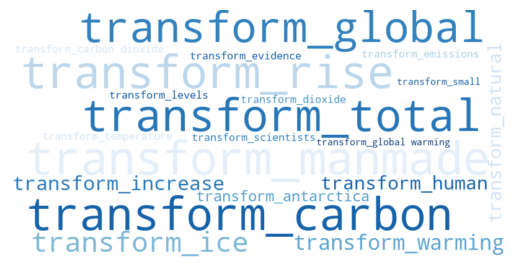

In [18]:
from src.utils import * 

fw = get_feature_importance(rf_model, top_n=20)   # works with RF, XGB or LogReg
plot_feature_importance(fw, "Random Forest Feature Importance")
plot_wordcloud(fw, model_type="rf")